In [23]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir("/Users/wvsharber/FlatironLessons/mod3project_Tanzania_water_well/")
from src.useful_func import do_everything, create_voting_classifier, create_graph, clean_data, drop_useless_cols, fix_dates, clean_data, bin_me, onehotmess
os.chdir("/Users/wvsharber/FlatironLessons/mod3project_Tanzania_water_well/competition/")

In [39]:
def drop_useless_cols(df, drop_values = []):
    """
    Drops columns from df that are specificied in drop_values. Won't drop values from continuous data columns, but will raise an error if you try. Returns DataFrame with columns dropped.
    """
    
    continuous_columns = ['amount_tsh', 'date_recorded', 'gps_height', 'population', 'construction_year']
    for cont in continuous_columns:
        if cont in drop_values:
            print(f'you cannot drop column: {cont}')
            return
        
    try:
        df_dropped = df.drop(drop_values, axis = 1)
        return df_dropped
    except:
        return df
    
def load_data(string1, string2):
    """
        Pass in two strings containg .csv file paths. This function will load the two dataframes and merge them along the column 'id'. Returns merged DataFrame.
    """
    df_1 = pd.read_csv(string1)
    df_2 = pd.read_csv(string2)
    #merging dataframes
    df = pd.merge(df_1, df_2, on = 'id', how = 'inner')
    return df

    
def fix_dates(df):
    """ 
    Takes the date of 01/01/2020 and subtracts it from the 'date_recorded' column. This information will be stored in column called 'days_since_recording' and drops the 'date_recorded' column from the DataFrame. Returns DataFrame.
    """
    basedate = datetime(2020, 1, 1)
    df['days_since_recording'] = df.loc[:,'date_recorded'].map(lambda x: (basedate - datetime.strptime(x, "%Y-%m-%d")).days)
    df.drop(['date_recorded'], axis = 1, inplace = True)
    return df

def clean_data(df, threshold = 100):
    """
    Replaces all NaN values in DataFrame with 'Not Known'. For categorical columns, replaces all values with a count less than 100 (threshold value) with 'other'. Returns edited DataFrame.
    """
    
    # replaces NaN with a string 'not known'
    df = df.fillna('Not Known')
    
    uvdict = {}

    for column in df.select_dtypes(exclude=['int','float']):
        values_list = df[column].unique()
        uvdict[column] = len(values_list)

    target_list = list(filter(lambda x: uvdict[x] > threshold, uvdict.keys()))
                       
                       
    for col in target_list:
        valued_dict = dict(df[col].value_counts())
        safe_values = list(key for key, value in valued_dict.items() if value >= 50)
    #     replace_values = list(filter(lambda x: x not in safe_values, all_values))
        df.loc[:, col] = df.loc[:, col].map(lambda y: 'other' if y not in safe_values else y)
    
    
    return df

def bin_me(df):
    """
    Creates bins for construction_year based on 5 year increments. In addition, values stored as year 0 will be transformed to 'not_available'. Returns edited DataFrame.
    """
    try:
        basedate = datetime(2020, 1, 1)
        a = list(range(1955,2016,5))
        cut_bins = [-1]
        cut_bins.extend(a)
        cut_labels = ['not available', '56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-00','01-05','06-10','11-15']
        df.loc[:, 'construction_year_bin'] = pd.cut(df['construction_year'], bins = cut_bins, labels = cut_labels)
        df.drop(['construction_year'], axis = 1, inplace = True)
        return df
    except:
        if 'construction_year_bin' in df.columns:
            print('action already performed')
        else:
            print('you messed up')

def onehotmess(df):
    """
    Uses pd.getdummies() to one hot encode categorical variables in DataFrame. Returns edited DataFrame and target DataFrame.
    """
    df_objects = df.select_dtypes(exclude=['int','float']).drop(['status_group'], axis = 1)
    df_nums = df.select_dtypes(include=['int','float'])

    df_onehot = pd.get_dummies(df_objects)

    df_final = pd.concat([df_nums, df_onehot], axis = 1)
    
    return df_final, df.status_group

def normalize_func(df_values, df_target):
    """
    Takes DataFrame of training data and target values, performs a train-test split, and then scales the data using MinMaxScaler. Returns train and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(df_values, df_target, test_size = .05, random_state = 42)
    scaler = MinMaxScaler()
    
    X_train_ = scaler.fit_transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    return X_train_, X_test_, y_train, y_test, scaler

In [40]:
def onehotencoder(df):
    df_objects = df.select_dtypes(exclude=['int','float']).drop(['status_group'], axis = 1)
    df_nums = df.select_dtypes(include=['int','float'])
    
    ohe = OneHotEncoder()
    onehot_array = ohe.fit_transform(df_objects)
    df_onehot = pd.DataFrame(onehot_array, columns = ohe.columns)
    
    df_final = pd.concat([df_nums, df_onehot], axis = 1)
    
    return df_final, df.status_group, ohe

    

In [41]:
def do_everything(string1, string2, drop_values, thresh = 200):
    """
    This function wraps previously defined data cleaning and preprocessing functions and returns processed train and test data sets.
    """
    loaded_data = load_data(string1, string2)
    df_dropped = drop_useless_cols(loaded_data, drop_values)
    fixed_date = fix_dates(df_dropped)
    cleaner_df = clean_data(fixed_date, thresh)
    df_binned = bin_me(cleaner_df)
    ohe_df, target_df, ohe = onehotencoder(df_binned)
    X_train, X_test, y_train, y_test, scaler = normalize_func(ohe_df, target_df)
    
    return X_train, X_test, y_train, y_test, ohe_df, target_df, ohe, scaler

In [71]:
string_1 = '../data/training_data_values.csv' #Your filepath to the data here
string_2 = '../data/training_data_labels.csv' #Your filepath to the data here
drop_columns = ['id', 'funder', 'num_private', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region_code', 'lga',
                'ward','recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'quality_group', 
                'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']


#X_train, X_test, y_train, y_test, df_values, df_target, ohe, scaler = do_everything(string_1, string_2, drop_columns)

In [72]:
loaded_data = load_data(string_1, string_2)
df_dropped = drop_useless_cols(loaded_data, drop_columns)
fixed_date = fix_dates(df_dropped)
cleaner_df = clean_data(fixed_date, 200)
df_binned = bin_me(cleaner_df)

In [73]:
df_coerced = df_binned.select_dtypes(exclude=['int','float']).astype('str')

In [74]:
df_target = df_binned['status_group']

In [75]:
df_coerced.drop(['status_group'], axis = 1, inplace = True)

In [82]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(df_coerced)
onehot_array = ohe.transform(df_coerced)

In [83]:
onehot_array

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [84]:
X_train, X_test, y_train, y_test, scaler = normalize_func(onehot_array, df_target)

In [85]:
RF1 = RandomForestClassifier(n_estimators = 200)
LR1 = LogisticRegression(max_iter = 1000)
GBR1 = GradientBoostingClassifier(n_estimators = 300)
KNN1 = KNeighborsClassifier()

#Hard-coded estimates of accuracy from previously fit models
lr_weight, rf_weight, gbr_weight, knn_weight = .77, .80, .78, .78

eclf_soft = VotingClassifier(estimators = [('lr', LR1),
                                           ('rf', RF1),
                                           ('gbr', GBR1),
                                           ('knn', KNN1)],
                             weights = [lr_weight, rf_weight, gbr_weight, knn_weight],
                             voting = 'soft')
eclf_soft.fit(X_train, y_train)
score = eclf_soft.score(X_test, y_test)

In [94]:
score

0.806060606060606

In [86]:
test_df = pd.read_csv("../data/test_data_values.csv")

In [92]:
thresh = 200

test_df_dropped = drop_useless_cols(test_df, drop_columns)
test_fixed_date = fix_dates(test_df_dropped)
test_cleaner_df = clean_data(test_fixed_date, thresh)
test_df_binned = bin_me(test_cleaner_df)
test_df_coerced = test_df_binned.select_dtypes(exclude=['int','float']).astype('str')
test_onehot_array = ohe.transform(test_df_coerced)

In [91]:
test_data = scaler.transform(test_onehot_array)

In [93]:
test_preds = eclf_soft.predict(test_data)

In [95]:
test_results = pd.concat([test_df['id'], pd.DataFrame(test_preds, columns = ['status_group'])], axis = 1)

In [99]:
test_results.to_csv("test_results.csv", index = False)

Achieves an accuracy of 0.7904 on submission website

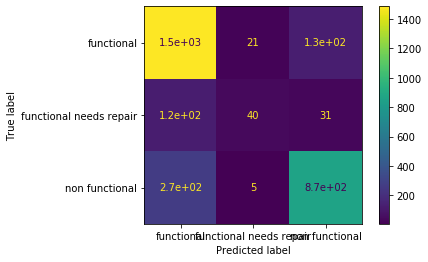

In [100]:
plot_confusion_matrix(eclf_soft, X_test, y_test)